In [46]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import random

import pandas as pd
import numpy as np
import pickle
import networkx as nx
import matplotlib.pyplot as plt

from tweet_recommendations.utils.metrics import get_mean_average_precision_at_k, get_rank_dcg_at_k

In [37]:
random.seed(1337)
config = {"rank_length": 3}
data = pd.DataFrame(data={'hashtag': ["a", "b", "c", "d", "e", "f", "g", "h"]})
testdict = {"tweet": ["123", "456", "789"], "expected_hashtags": [["a", "c", "g"], ["c", "d", "f"], ["a", "d", "h"]]}
testset = pd.DataFrame(data=testdict)

def get_k_random_hashtags_from_hashtag_data(hashtag_data: pd.DataFrame, k=10):
    hashtag_range = len(hashtag_data)
    hashtag_list = []
    for i in range(k):
        hashtag_list.append(
            hashtag_data.iloc[random.randint(0, hashtag_range - 1)]["hashtag"]
        )
    return hashtag_list


def get_hashtag_rank_for_given_tweets(tweet: str, hashtag_data: pd.DataFrame, config: dict):
    return get_k_random_hashtags_from_hashtag_data(
        hashtag_data, config["rank_length"]
    )


def get_metrices_for_given_dataset(test_set: pd.DataFrame, config: dict, hashtag_data=None):
    test_mAP, test_ndcg = zip(*test_set.apply(lambda row: get_metrices_for_given_row(config, hashtag_data, row), axis=1).tolist())
    return np.mean(np.asarray(test_mAP)), np.mean(np.asarray(test_ndcg))


def get_metrices_for_given_row(config, hashtag_data, row):
    predicted_hashtag_rank = get_hashtag_rank_for_given_tweets(
        row["tweet"], hashtag_data, config
    )
    expected_hashtags = row["expected_hashtags"]
    return get_mean_average_precision_at_k(expected_hashtags, predicted_hashtag_rank, config["rank_length"]), get_rank_dcg_at_k(expected_hashtags, predicted_hashtag_rank, config["rank_length"])


In [38]:
get_metrices_for_given_dataset(testset, config, data)

(0.2222222222222222, 0.08333333333333327)

In [34]:
def get_datasets():
    all_tweets = pd.read_pickle('../data/source_data/original_tweets.p')
    all_tweets['hashtags'] = all_tweets['hashtags'].apply(lambda x: [h['text'] for h in x])

    skipgrams = pd.read_pickle('../data/embeddings/skipgram_embeddings.pkl')
    skipgrams['id'] = skipgrams['tweet_id'].astype(int)
    skipgrams = skipgrams.drop(columns=['tweet_id']).rename(columns={'tweet_embedding': 'skipgram'})
    fasttexts = pd.read_pickle('../data/embeddings/fasttext_embeddings.pkl')
    fasttexts['id'] = fasttexts['tweet_id'].astype(int)
    fasttexts = fasttexts.drop(columns=['tweet_id']).rename(columns={'embeddings': 'fasttext'})

    with open('../data/graphs/train_graph.p', 'rb') as f:
        train_g = pickle.load(f)

    with open('../data/graphs/val_graph.p', 'rb') as f:
        val_g = pickle.load(f)

    with open('../data/graphs/test_graph.p', 'rb') as f:
        test_g = pickle.load(f)

    all_tweets = all_tweets[['id', 'text', 'retweet_count', 'hashtags']]
    all_tweets = all_tweets.merge(skipgrams, on='id')
    all_tweets = all_tweets.merge(fasttexts, on='id')

    def prepare_df(all_tweets, graph):
        tweet_ids = [node_id for node_id in graph.nodes 
                     if graph.nodes[node_id]['node_type'] == 'tweet']
        nodes = pd.DataFrame({'id': tweet_ids})
        return all_tweets.merge(nodes, on='id')

    train_df = prepare_df(all_tweets, train_g)
    validation_df = prepare_df(all_tweets, val_g)
    test_df = prepare_df(all_tweets, test_g)
    popular_test_df = test_df[test_df['retweet_count']>0]
    unpopular_test_df = test_df[test_df['retweet_count']==0]
    return train_df, validation_df, test_df, popular_test_df, unpopular_test_df

In [35]:
train_df, validation_df, test_df, popular_test_df, unpopular_test_df = get_datasets()

KeyError: 51

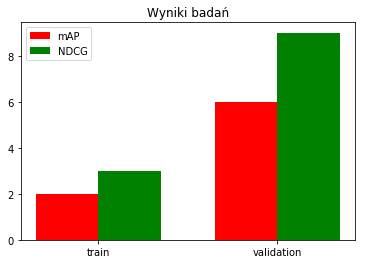

In [63]:
train_map_at_k, train_ndcg_at_k = get_metrices_for_given_dataset(train_df, config)
valid_map_at_k, valid_ndcg_at_k = get_metrices_for_given_dataset(validation_df, config)
test_map_at_k, test_ndcg_at_k = get_metrices_for_given_dataset(test_df, config)
popular_test_map_at_k, popular_test_ndcg_at_k = get_metrices_for_given_dataset(popular_test_df, config)
unpopular_test_map_at_k, unpopular_test_ndcg_at_k = get_metrices_for_given_dataset(unpopular_test_df, config)

results = [
    (train_map_at_k, train_ndcg_at_k),
    (valid_map_at_k, valid_ndcg_at_k),
    (test_map_at_k, test_ndcg_at_k),
    (popular_test_map_at_k, popular_test_ndcg_at_k),
    (unpopular_test_map_at_k, unpopular_test_ndcg_at_k)
]

X = np.arange(len(results))
ys = list(zip(*results))
width = 0.35 

fig, ax = plt.subplots()

map_bar = ax.bar(X, ys[0], width, color='r')
ndcg_bar = ax.bar(X+width, ys[1], width, color='g')

plt.title("Wyniki badań")
ax.set_xticks(X + width / 2)
ax.set_xticklabels(["train", "validation", "test", "test pop", "test unpop"])

plt.legend((map_bar, ndcg_bar), ("mAP", "NDCG"))